In [1]:
cd '/h/ama/workspace/ama-at-vector/best-mix'

/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix


In [2]:
import torchvision.models as models
import torchvision

import torch
from PIL import Image
import torchvision.transforms as transforms

import matplotlib.pyplot as plt 
import ipdb
from matplotlib.pyplot import figure

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import ipdb
import copy
from tqdm import trange
from PIL import Image
import PIL
import numpy as np
import torchvision

_device = torch.device('cuda:0')

In [3]:
top = cm.get_cmap('Reds', 128)
bottom = cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(1, 0, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [4]:
model = models.resnext50_32x4d(pretrained=True)
model.to(_device)
print('loaded')

loaded


In [5]:
data_path = '/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix/notebook/images/'

image_1 = Image.open(data_path+'African_hunting_dog_275_cropped.jpeg')
# image_2 = Image.open(data_path+'Maltese_dog_1_153.png')
image_2 = Image.open(data_path+'tabby_cat_3_281_cropped.png')
target_1 = torch.tensor([275],device=_device)
target_2 = torch.tensor([281],device=_device)
# target_2 = torch.tensor([153],device=_device)

# image_1 = Image.open(data_path+'Persian_cat_283.JPEG')
# image_2 = Image.open(data_path+'tabby_cat_3_281.png')
# target_1 = torch.tensor([283],device=_device)
# target_2 = torch.tensor([281],device=_device)



transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize([200,200])
])

img_1 = (transform(image_1)[:3,:,:].float()/255.).unsqueeze(0).to(_device)
# img_2 = (transform(image_2)[:3,:,:].float()/255.).unsqueeze(0).to(_device)
img_2 = (transform(image_2)[:3,:,:].float()/255.).unsqueeze(0).to(_device)
# img_4 = (transform(image_4)[:3,:,:].float()/255.).unsqueeze(0).to(_device)

blurr = torchvision.transforms.GaussianBlur(21, sigma=(13, 13))

In [6]:
model.eval()

delta = torch.zeros_like(img_1, requires_grad = True,device=_device)
yp = model(img_1+delta)
loss = torch.nn.CrossEntropyLoss()(yp, target_1)
loss.backward()

grad_1 = blurr(delta.grad.detach().abs().mean(dim=1))

delta = torch.zeros_like(img_2, requires_grad = True,device=_device)
yp = model(img_2+delta)
loss = torch.nn.CrossEntropyLoss()(yp, target_2)
loss.backward()

grad_2 = blurr(delta.grad.detach().abs().mean(dim=1))

input_sp = torch.cat([img_1, img_2])
targets = torch.cat([target_1, target_2])
grad = torch.cat([grad_1, grad_2])

In [102]:
from utils_wip import *
def gradmix_v2_improved_v4(x, y, grad, alpha=1, normalization='standard', debug=False, rand_pos=1):
    '''Returns mixed inputs, pairs of targets, and lambda'''
####################################################################################
    # init a bunch of variables
    batch_size, c, w, h = np.array(x.size())
    if debug:
        index = torch.tensor([1,4,3,0,2]).cuda()
    else:
        # comment/uncomment here for reproducing the same results
#         index = torch.range(start=99, end=0, step=-1, dtype=int, device = x.device)
#         index = torch.randperm(batch_size, device = x.device)
        index = torch.tensor([1,0])

    mixed_y = [y, y[index]]
    grad_1, grad_2 = grad, grad[index, :]

#     best_ij = torch.zeros([batch_size, 2], dtype=int, device = x.device)
    best_ij = torch.ones([batch_size, 2], dtype=int, device = x.device)*w
#     best_ij
    mixed_x = torch.zeros_like(x, device = x.device)
    _mixed_lam = torch.zeros([batch_size], device = x.device)

    normalized_grad_1 = normalize_grad(grad_1, alpha, normalization)
    normalized_grad_2 = normalize_grad(grad_2, 1-alpha, normalization)
    padded_normalized_grad_1 = pad_zeros(normalized_grad_1, w,w,w,w)
    padded_normalized_grad_2 = pad_zeros(normalized_grad_2, w,w,w,w)
    padded_x_1 = pad_zeros(x, w,w,w,w)
    padded_x_2 = pad_zeros(x[index,:], w,w,w,w)

    possible_positions_per_axis = int((2*w-1))
    actual_positions = int(possible_positions_per_axis**2*rand_pos)
    _x = torch.linspace(1, 2*w-1, possible_positions_per_axis, dtype=int, device=x.device)    
    _xv, _yv = torch.meshgrid(_x, _x, indexing='xy')
    rand_perm = torch.randperm(possible_positions_per_axis**2, device=x.device)
    # comment/uncomment here for reproducing the same results
    coord = torch.stack((_xv.flatten(), _yv.flatten()))[:,rand_perm[:actual_positions]]
#     coord = torch.stack((_xv.flatten(), _yv.flatten()))[:,:actual_positions]
    coord = torch.ones_like(coord)*w
    coord[0,:] = 100*1
    
    coord[1,:] = 100*3
#     ipdb.set_trace()
    
####################################################################################
#     iterate over images and find the best position that maximizes saliency
    theta = torch.eye(2,3,device=x.device).repeat(coord.shape[1],1,1)
    theta[:,0,2] = 2*(w-coord[1,:])/(3*w)
    theta[:,1,2] = 2*(w-coord[0,:])/(3*w)
    size = torch.Size((coord.shape[1],1,3*w,3*w))
    grid = F.affine_grid(theta, size, align_corners=False)
    
    saliency_output = []
    for img in range(batch_size):
        single_padded_normalized_grad_2 = padded_normalized_grad_2[img].expand(coord.shape[1],1,3*w,3*w)
        translated_single_padded_normalized_grad_2 = F.grid_sample(single_padded_normalized_grad_2,
                                                             grid,
                                                             mode='nearest',
                                                             padding_mode ='zeros',
                                                             align_corners=False)

        single_padded_normalized_grad_1 = padded_normalized_grad_1[img].expand(coord.shape[1],1,3*w,3*w)

        M =  single_padded_normalized_grad_1 / (single_padded_normalized_grad_1+translated_single_padded_normalized_grad_2+1e-12)

        saliency = return_center(single_padded_normalized_grad_1 * M+(translated_single_padded_normalized_grad_2 * (1-M)), w)
#         ipdb.set_trace()

#         best_ij[img,:] = coord[:,saliency.sum(dim=[1,2,3]).argmax()]
        best_ij[img,:] = coord[:,3]
        
#         saliency_output.append(saliency.sum(dim=[1,2,3]).max())
        saliency_output.append(saliency.sum(dim=[1,2,3])[3])
    
####################################################################################
    # update mixed images
    theta = torch.eye(2,3,device=x.device).repeat(batch_size,1,1)
    theta[:,0,2] = 2*(w-best_ij[:,1])/(3*w)
    theta[:,1,2] = 2*(w-best_ij[:,0])/(3*w)
    size = torch.Size((batch_size,c,3*w,3*w))
    grid = F.affine_grid(theta, size, align_corners=False)

    translated_padded_normalized_grad_2 = F.grid_sample(padded_normalized_grad_2,
                                                         grid,
                                                         mode='nearest',
                                                         padding_mode ='zeros',
                                                         align_corners=False)
    M = (padded_normalized_grad_1 / (padded_normalized_grad_1+translated_padded_normalized_grad_2+1e-12))
#     ipdb.set_trace()
#     mixed_saliency = return_center((torch.mul(single_padded_normalized_grad_1[0], M[1]) + torch.mul(single_padded_normalized_grad_2[0], 1-M[1])).unsqueeze(0), w)
    
#     mixed_saliency = (padded_normalized_grad_1 / (padded_normalized_grad_1+translated_padded_normalized_grad_2+1e-12))
    
    lambbda = return_center(M,w).mean(dim=[1,2,3])
    translated_padded_x_2 = F.grid_sample(padded_x_2,
                                          grid,
                                          mode='nearest',
                                          padding_mode ='zeros',
                                          align_corners=False)
    mixed_x = return_center(torch.mul(padded_x_1, M) + torch.mul(translated_padded_x_2, 1-M), w)
    _mixed_lam = lambbda

    mixed_lam = [_mixed_lam.detach(), 1- _mixed_lam.detach()]
#     ipdb.set_trace()

#     del _mixed_lam, index, M, grid, size, theta, translated_padded_x_2, coord
#     del padded_normalized_grad_1, padded_normalized_grad_2, normalized_grad_1, normalized_grad_2, padded_x_1, padded_x_2, best_ij

#     padded_normalized_grad_1 = pad_zeros(normalized_grad_1, w,w,w,w)
#     padded_normalized_grad_2 = pad_zeros(normalized_grad_2, w,w,w,w)



    mixed_saliency = return_center(torch.mul(padded_normalized_grad_1, M) + torch.mul(translated_padded_normalized_grad_2, 1-M), w)

#     mixed_saliency = torch.zeros([1,3,200,200])
#     mixed_saliency[0,0,:,:] = return_center(torch.mul(translated_padded_normalized_grad_2, 1-M), w)[0]
#     mixed_saliency[0,2,:,:] = return_center(torch.mul(padded_normalized_grad_1, M), w)[0]
#     ipdb.set_trace()
    
    return mixed_x.detach(), mixed_y, mixed_lam, return_center(M,w), normalized_grad_1, normalized_grad_2, saliency_output, mixed_saliency

[tensor(0.4735, device='cuda:0'), tensor(0.4846, device='cuda:0')]


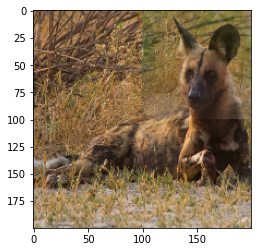

In [103]:
mixed_x, mixed_y, mixed_lam, M, normalized_grad_1, normalized_grad_2, saliency_output, mixed_saliency = gradmix_v2_improved_v4(input_sp, targets, grad.unsqueeze(1), 
                                                 alpha = 0.5, normalization = 'L1', debug=False, 
                                                 rand_pos = 0.001)
plt.imshow(mixed_x[0].squeeze().permute(1, 2, 0).cpu().numpy())
print(saliency_output)

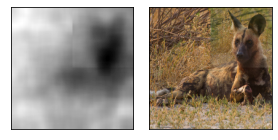

In [104]:
fix, axs = plt.subplots(ncols=2, nrows=1, squeeze=True, figsize=(4,2))

# im = axs.flat[0].imshow((mixed_saliency[0]).detach().cpu()[0].squeeze(), cmap = 'binary')
im = axs.flat[0].imshow(torch.log(mixed_saliency[0]).detach().cpu()[0].squeeze(), cmap = 'binary')
axs.flat[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# fix.colorbar(im,ax = axs.flat[0])

im = axs.flat[1].imshow(mixed_x[0].squeeze().permute(1, 2, 0).cpu().numpy())
axs.flat[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.tight_layout()

tensor(0.5949, device='cuda:0')


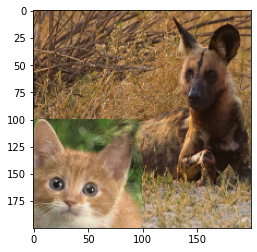

In [75]:
mixed_x_new, mixed_y, mixed_lam, M_new, normalized_grad_1, normalized_grad_2, saliency_output_new, mixed_saliency_new = gradmix_v2_improved_v4(input_sp, targets, grad.unsqueeze(1), 
                                                 alpha = 0.5, normalization = 'L1', debug=False, 
                                                 rand_pos = 0.001)
plt.imshow(mixed_x_new[0].squeeze().permute(1, 2, 0).cpu().numpy())
print(saliency_output_new[0].sum())

In [17]:
padded_normalized_grad_1.sum()

tensor(1., device='cuda:0')

In [31]:
mixed_x_exp, mixed_y, mixed_lam, M_exp, normalized_grad_1, normalized_grad_2,saliency_output_exp = gradmix_v2_improved_v4(input_sp, targets, grad.unsqueeze(1), 
                                                 alpha = 0.5, normalization = 'L1', debug=False, 
                                                 rand_pos = 0.0001)
# plt.imshow(mixed_x_exp[0].squeeze().permute(1, 2, 0).cpu().numpy())
fix, axs = plt.subplots(ncols=2, nrows=1, squeeze=True, figsize=(20,7))
im = axs.flat[0].imshow(M_exp.detach().cpu()[0].squeeze(), cmap = newcmp)
axs.flat[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[0])
axs.flat[0].set_title(r'mask =$\frac{g1}{g1+g2}$')

# mixed_x = (torch.tensor(saliency_M).cuda().unsqueeze(2) * img_1.squeeze().permute(1,2,0)) + (torch.tensor(1-saliency_M).cuda().unsqueeze(2) * img_2.squeeze().permute(1,2,0))
im = axs.flat[1].imshow(mixed_x_exp[0].squeeze().permute(1, 2, 0).cpu().numpy())
axs.flat[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs.flat[1].set_title('mixed images with our method')

print(saliency_output_exp)

ValueError: too many values to unpack (expected 7)

[tensor(0.4744, device='cuda:0'), tensor(0.4601, device='cuda:0')]


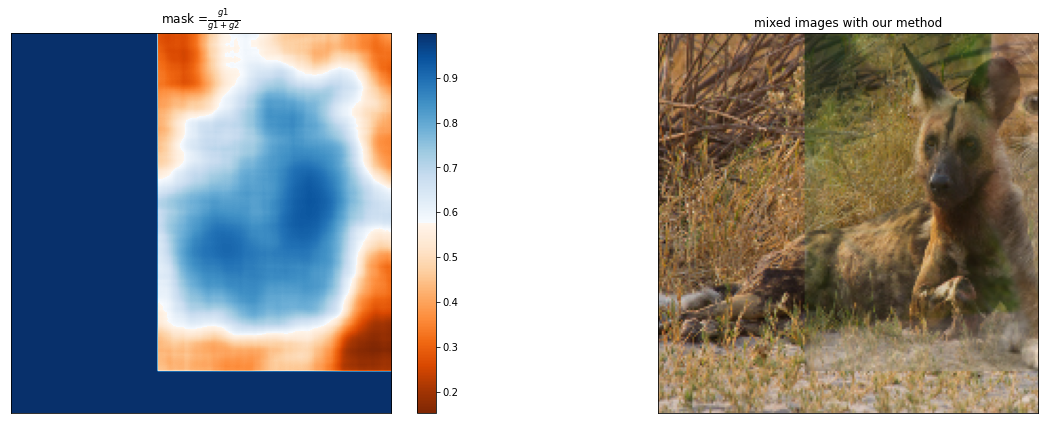

In [67]:
mixed_x_exp, mixed_y, mixed_lam, M_exp, normalized_grad_1, normalized_grad_2,saliency_output_exp = gradmix_v2_improved_v4(input_sp, targets, grad.unsqueeze(1), 
                                                 alpha = 0.5, normalization = 'L1', debug=False, 
                                                 rand_pos = 0.0001)
# plt.imshow(mixed_x_exp[0].squeeze().permute(1, 2, 0).cpu().numpy())
fix, axs = plt.subplots(ncols=2, nrows=1, squeeze=True, figsize=(20,7))
im = axs.flat[0].imshow(M_exp.detach().cpu()[0].squeeze(), cmap = newcmp)
axs.flat[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[0])
axs.flat[0].set_title(r'mask =$\frac{g1}{g1+g2}$')

# mixed_x = (torch.tensor(saliency_M).cuda().unsqueeze(2) * img_1.squeeze().permute(1,2,0)) + (torch.tensor(1-saliency_M).cuda().unsqueeze(2) * img_2.squeeze().permute(1,2,0))
im = axs.flat[1].imshow(mixed_x_exp[0].squeeze().permute(1, 2, 0).cpu().numpy())
axs.flat[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs.flat[1].set_title('mixed images with our method')

print(saliency_output_exp)

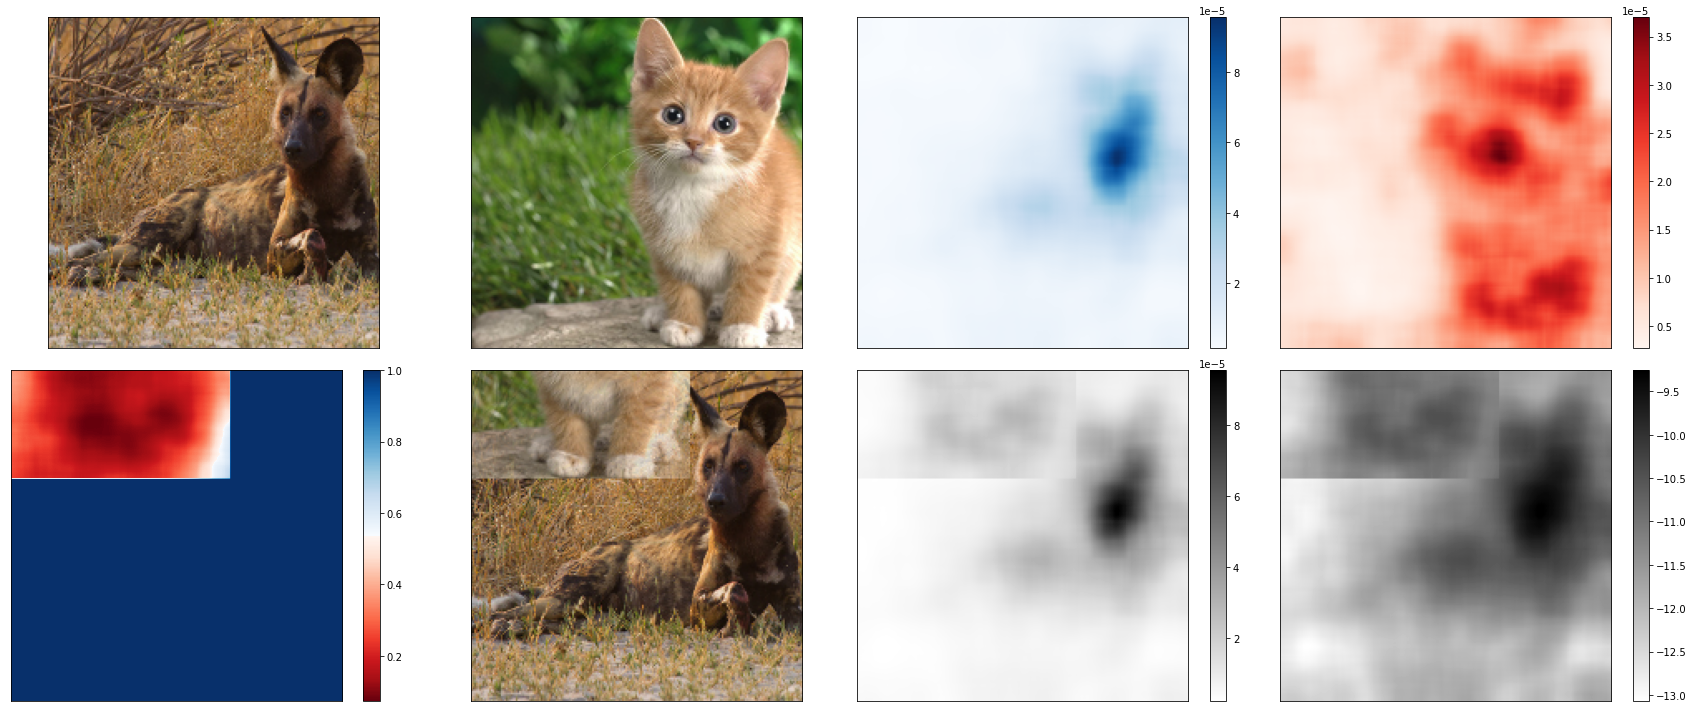

In [24]:
fix, axs = plt.subplots(ncols=4, nrows=2, squeeze=True, figsize=(24,10))

# for i,ax in enumerate(axs.flat):
im = axs.flat[0].imshow(img_1.squeeze().permute(1, 2, 0).cpu().numpy())
axs.flat[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# axs.flat[0].set_title('x0: tabby cat')
im = axs.flat[1].imshow(img_2.squeeze().permute(1, 2, 0).cpu().numpy())
axs.flat[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# axs.flat[1].set_title('x1: african hunting dog')

im = axs.flat[2].imshow(normalized_grad_1[0].squeeze().t().permute(1,0).cpu().numpy(), cmap = 'Blues')
axs.flat[2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[2])
# axs.flat[2].set_title('g0')

im = axs.flat[3].imshow(normalized_grad_1[1].squeeze().t().permute(1,0).cpu().numpy(), cmap = 'Reds')
axs.flat[3].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[3])
# axs.flat[3].set_title('g1')

# saliency_M = grad_1.t().permute(1,0).cpu().numpy()/(grad_2.t().permute(1,0).cpu().numpy()+grad_1.t().permute(1,0).cpu().numpy()+1e-6)
# im = axs.flat[4].imshow(torch.log(mixed_saliency[0]).detach().cpu()[0].squeeze(), cmap = 'binary')
# im = axs.flat[4].imshow(M.detach().cpu()[0].squeeze(), cmap = newcmp)
im = axs.flat[4].imshow(M.detach().cpu()[0].squeeze(), cmap = newcmp)
axs.flat[4].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[4])
# axs.flat[4].set_title(r'mask =$\frac{g1}{g1+g2}$')

# mixed_x = (torch.tensor(saliency_M).cuda().unsqueeze(2) * img_1.squeeze().permute(1,2,0)) + (torch.tensor(1-saliency_M).cuda().unsqueeze(2) * img_2.squeeze().permute(1,2,0))
im = axs.flat[5].imshow(mixed_x[0].squeeze().permute(1, 2, 0).cpu().numpy())
axs.flat[5].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# axs.flat[5].set_title('mixed images with our method')

# saliency_M = grad_1.t().permute(1,0).cpu().numpy()/(grad_2.t().permute(1,0).cpu().numpy()+grad_1.t().permute(1,0).cpu().numpy()+1e-6)
# im = axs.flat[6].imshow(M_new.detach().cpu()[0].squeeze(), cmap = newcmp)
im = axs.flat[6].imshow(mixed_saliency[0].detach().cpu()[0].squeeze(), cmap = 'binary')
axs.flat[6].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[6])
# axs.flat[6].set_title(r'mask =$\frac{g1}{g1+g2}$')

# mixed_x = (torch.tensor(saliency_M).cuda().unsqueeze(2) * img_1.squeeze().permute(1,2,0)) + (torch.tensor(1-saliency_M).cuda().unsqueeze(2) * img_2.squeeze().permute(1,2,0))
im = axs.flat[7].imshow(torch.log(mixed_saliency[0]).detach().cpu()[0].squeeze(), cmap = 'binary')
# mixed_saliency[mixed_saliency==0] = 1
# plot_mixed_saliency = mixed_saliency.detach().clone()
# plot_mixed_saliency_min = plot_mixed_saliency.min()
# plot_mixed_saliency -= plot_mixed_saliency_min
# plot_mixed_saliency_max = mixed_saliency.max()
# plot_mixed_saliency /= plot_mixed_saliency_max
# plot_mixed_saliency =plot_mixed_saliency.squeeze().permute(1, 2, 0).cpu().numpy()
# fix.set_facecolor("white")
# plot_mixed_saliency[plot_mixed_saliency[:,:,0]==0,0] = 1
# im = axs.flat[7].imshow(plot_mixed_saliency[:,:,2], cmap = 'Blues')
# im = axs.flat[7].imshow(plot_mixed_saliency[:,:,0], cmap = 'Reds'  ,alpha=0.3)



axs.flat[7].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[7])
# axs.flat[7].set_title('mixed images with our method')

plt.tight_layout()

In [321]:
plot_mixed_saliency[:,:,0].max()

3.359396e-05

In [301]:
plot_mixed_saliency.sum()

0.5675743

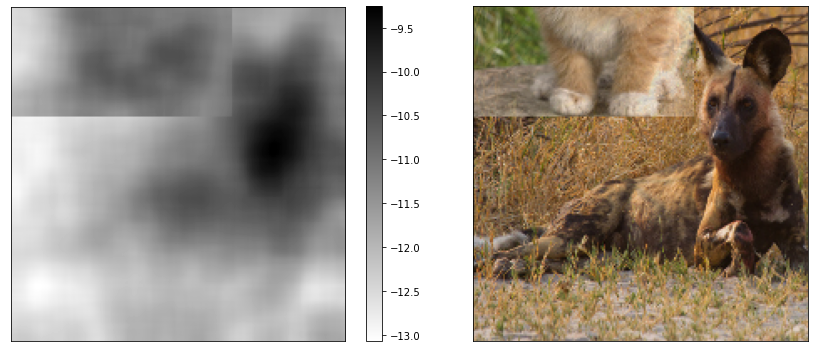

In [25]:
fix, axs = plt.subplots(ncols=2, nrows=1, squeeze=True, figsize=(12,5))

# im = axs.flat[0].imshow((mixed_saliency[0]).detach().cpu()[0].squeeze(), cmap = 'binary')
im = axs.flat[0].imshow(torch.log(mixed_saliency[0]).detach().cpu()[0].squeeze(), cmap = 'binary')
axs.flat[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
fix.colorbar(im,ax = axs.flat[0])

im = axs.flat[1].imshow(mixed_x[0].squeeze().permute(1, 2, 0).cpu().numpy())
axs.flat[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.tight_layout()